In [1]:
import pandas as pd
import os
import time
from transformers import pipeline

In [2]:
PATH_CONSOLIDADO = '../data_consolidated/'
files = sorted(os.listdir(PATH_CONSOLIDADO))
files

['dataTW_GP__(@JaimeChincha.csv',
 'dataTW_GP__(RMP.csv',
 'dataTW_GP__@JaimeChincha.csv',
 'dataTW_GP__@interbank.csv',
 'dataTW_GP__Malcricarmen.csv',
 'dataTW_GP__Vacancia.csv',
 'dataTW_GP__hildebrant.csv',
 'dataTW_GP__repsol.csv',
 'dataTW_GP__willax.csv',
 'usersTW_GP__(@JaimeChincha.csv',
 'usersTW_GP__(RMP.csv',
 'usersTW_GP__@JaimeChincha.csv',
 'usersTW_GP__@interbank.csv',
 'usersTW_GP__Malcricarmen.csv',
 'usersTW_GP__Vacancia.csv',
 'usersTW_GP__hildebrant.csv',
 'usersTW_GP__repsol.csv',
 'usersTW_GP__willax.csv']

In [3]:
data = {}
for file in files:
    data[file] = pd.read_csv(os.path.join(PATH_CONSOLIDADO, file))

In [4]:
def get_public_metrics(dataset):
    '''Extrae la columna "public_metrics" que se encuentra en el dataset'''
    df_public = pd.DataFrame()
    for i, row in dataset.iterrows():
        public_metrics = eval(row['public_metrics'])
        public_metrics['id'] = row['id']
        df_i = pd.DataFrame([public_metrics])
        df_public = df_public.append(df_i).reset_index(drop=True)        
    return df_public

def get_referenced_tweets(dataset):
    '''Extrae la columna "referenced_tweets" que se encuentra en el dataset'''
    df_referenced = pd.DataFrame()
    for i, row in dataset.iterrows():
        try:
            referenced_tweets = eval(row['referenced_tweets'])[0]
            referenced_tweets['id_ref'] = referenced_tweets['id']
        except:
            referenced_tweets = {}
        referenced_tweets['id'] = row['id']

        df_i = pd.DataFrame([referenced_tweets])
        df_referenced = df_referenced.append(df_i)
    return df_referenced

def get_mentions(text):
    '''Extrae las cuentas de twitter mencionadas'''
    split = text.split('@')
    mentions = [f"@{x.split(' ')[0]}" for x in split if len(x.split(' ')[0]) > 4]
    return mentions

def get_clean_text(text):
    '''Limpia el texto eliminando las menciones'''
    split = text.split('@')
    mentions = [f"@{x.split(' ')[0]}" for x in split if len(x.split(' ')[0]) > 4]
    
    for mention in mentions:
        text = text.replace(mention, '')
    text = text.replace('  ', ' ').replace('  ', ' ').replace('  ', ' ')
    text = text.replace(' ,', '')
    text = text.replace('\n', '').strip()
    return text


def get_sentiment_and_prob(text, sentiment):
    '''Evaluates and predicts the sentiment based on a text'''
    pred = sentiment(text)[0]
    preds = int(pred['label'][0]) + pred['score']
    return preds


def process_json_cols(dataset, print_progress=False):
    '''Realiza todo el procesamiento de limpieza con las funciones antes definidas'''
    start_time = time.time()
    dataset_1 = dataset.copy()
    
    # Obtaining Json Data
    public_metrics = get_public_metrics(dataset)
    referenced_tweets = get_referenced_tweets(dataset)
    
    # Merging Json Data
    dataset_1 = dataset_1.merge(public_metrics, on='id', how='left')
    dataset_1 = dataset_1.merge(referenced_tweets, on='id', how='left')
    dataset_1 = dataset_1.drop(['public_metrics', 'geo', 'referenced_tweets'], axis=1)
    
    # Cleaning Data
    dataset_1['mentions'] = dataset_1['text'].apply(get_mentions)
    dataset_1['num_mentions'] = dataset_1['mentions'].str.len()
    dataset_1['clean_text'] = dataset_1['text'].apply(get_clean_text)
    
    # Process Sentiment Data
    dataset_1['sentiment_output'] = dataset_1['clean_text'].apply(get_sentiment_and_prob, args=[sentiment])
    dataset_1['sentiment_pred'] = (dataset_1['sentiment_output']//1).astype(int)
    dataset_1['sentiment_conf'] = dataset_1['sentiment_output']%1
    
    processing_time = (time.time() - start_time)
    
    if print_progress:
        print(f'INFO: Processing Time:\t{processing_time:.2f} seconds')

    return dataset_1

In [5]:
# Initialize Sentiment Model
sentiment = pipeline(task = 'sentiment-analysis',
                     model = 'nlptown/bert-base-multilingual-uncased-sentiment',
                     tokenizer = 'nlptown/bert-base-multilingual-uncased-sentiment')

Downloading: 100%|██████████| 639M/639M [02:43<00:00, 4.10MB/s]
2022-02-19 08:50:40.703019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [6]:
dataset = data['dataTW_GP__(@JaimeChincha.csv']

In [7]:
dataset = process_json_cols(dataset, print_progress=True)

INFO: Processing Time:	141.72 seconds


<AxesSubplot:>

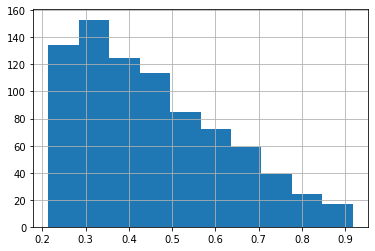

In [8]:
dataset['sentiment_conf'].hist()

In [141]:
dataset[['clean_text','sentiment_output']].iloc[4]

clean_text          Gracias a las personas..*Aplaude*
sentiment_output                             5.646634
Name: 4, dtype: object

In [9]:
dataset['clean_text'].to_list()[:10]

['Qué les pareció?',
 'Ahora pues https://t.co/G0tax9PNxd',
 'Dos sobones dos chupes 2 caviares UN CAMINO en la emisora del Oficialismo Chavista Atatauuu.. ajjjjjj',
 'a escuchar al gran Cesar H. Con ahorita en vivo',
 'Gracias a las personas..*Aplaude*',
 'Los mismos de ventanilla ni saben que es un distrito del callao 🤣 nadie me lo contó yo lo he visto',
 'Si porque las preguntas que le hicieron Mavila Huertas, Pedro Tenorio y Jaime Chincha no cuentan, porque no son milagros Leiva',
 'LOS RESPONSABLES SON REPSOL Y EL INEPTO DE CASTILLO QUE SE DEMORO EN REACCIONAR! PARA VARIAR ESTANA HACIENDO CUALQUIER COSA MENOS GOBERNAR',
 'Es lo único que saben estos rojos, ahuyentar a los inversionistas sin proponer soluciones.',
 'El detalle Jaime es que intentas emular una suerte de hibrido entre Jaime Bayliy Cesar Hildebrant. Sumado al ego colosal que tienes y es fácil caer en engrandecerse teniendo una generación de periodistas buitres y limitados donde resulta usted es el único que lee o argu

In [11]:
users = data['usersTW_GP__hildebrant.csv']

In [12]:
users.sample(3)

,username,verified,name,id,public_metrics,description,created_at,keyword,timestamp
400,UnRensentidoPe,False,Un Rensentido mas,1485788975633731584,"{'followers_count': 1, 'following_count': 16, ...",Un usuario mas en esta red social virulenta,2022-01-25T01:38:09.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:03.35
1743,arnaez_andres1,False,ANDRES ARNAEZ,1461446491210457093,"{'followers_count': 56, 'following_count': 267...","El deporte, turismo y la musica",2021-11-18T21:30:02.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:14:59.65
30,victorchin777,False,victor puma,41396371,"{'followers_count': 220, 'following_count': 16...",sigo en el camino de la medicina veterinaria,2009-05-20T16:49:30.000Z,hildebrant -is:retweet lang:es,2022-02-18 19:20:49.63


# Sentiment Analysis

In [11]:
from transformers import pipeline

In [ ]:
pipe = pipeline("sentiment-analysis", model="<your_model_here>", tokenizer="<your_tokenizer_here>")

In [12]:
sa = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
sa("We are happy to be in last session of the course")

[{'label': 'POSITIVE', 'score': 0.999824583530426}]

In [ ]:
sa("The movie was really bad")

[{'label': 'NEGATIVE', 'score': 0.99980229139328}]

In [ ]:
sa("I don't mind walking")

[{'label': 'POSITIVE', 'score': 0.7957820296287537}]

In [ ]:
sa_es = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
sa_es("El producto es excelente")

[{'label': '5 stars', 'score': 0.6660403609275818}]

In [ ]:
sa_es("No me gustó mucho la comida")

[{'label': '2 stars', 'score': 0.5694628357887268}]

# Named Entity Recognition

In [ ]:
ner = pipeline("ner")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

"""Bitcoin has jumped past $30,000 as Elon Musk said Tesla is "most likely" to start accepting it as payment again."""

In [ ]:
text = """Bitcoin has jumped past $30,000 as Elon Musk said Tesla is "most likely"
          to start accepting it as payment again."""

In [ ]:
[print(r) for r in ner(text)]

{'entity': 'I-PER', 'score': 0.9992423, 'index': 12, 'word': 'El', 'start': 35, 'end': 37}
{'entity': 'I-PER', 'score': 0.9975107, 'index': 13, 'word': '##on', 'start': 37, 'end': 39}
{'entity': 'I-PER', 'score': 0.9971636, 'index': 14, 'word': 'Mu', 'start': 40, 'end': 42}
{'entity': 'I-PER', 'score': 0.9745453, 'index': 15, 'word': '##sk', 'start': 42, 'end': 44}
{'entity': 'I-ORG', 'score': 0.9316861, 'index': 17, 'word': 'Te', 'start': 50, 'end': 52}
{'entity': 'I-ORG', 'score': 0.94788617, 'index': 18, 'word': '##sla', 'start': 52, 'end': 55}


[None, None, None, None, None, None]

In [141]:
dataset['text'].values[-1]

'A los Guaripoleros @DeltaMdelta @JaimeChincha @MavilaHuertasC se le suma @ensustrece con una merme entrevista, luego @NicolasLucar los trolls preparan ya 👏👏👏👏 @EIPeruano @LaSalitadelSin @RecuerdosPeru @eloymarchan @Angelpaezs @jgodoym @TrujiYo https://t.co/gWOQUoIHVg'

In [142]:
text = 'A los Guaripoleros @DeltaMdelta @JaimeChincha @MavilaHuertasC se le suma @ensustrece con una merme entrevista, luego @NicolasLucar los trolls preparan ya 👏👏👏👏 @EIPeruano @LaSalitadelSin @RecuerdosPeru @eloymarchan @Angelpaezs @jgodoym @TrujiYo https://t.co/gWOQUoIHVg'

In [147]:
split = text.split('@')
split

['A los Guaripoleros ',
 'DeltaMdelta ',
 'JaimeChincha ',
 'MavilaHuertasC se le suma ',
 'ensustrece con una merme entrevista, luego ',
 'NicolasLucar los trolls preparan ya 👏👏👏👏 ',
 'EIPeruano ',
 'LaSalitadelSin ',
 'RecuerdosPeru ',
 'eloymarchan ',
 'Angelpaezs ',
 'jgodoym ',
 'TrujiYo https://t.co/gWOQUoIHVg']

In [157]:
[f"@{x.split(' ')[0]}" for x in split if len(x.split(' ')[0]) > 4]

['@DeltaMdelta',
 '@JaimeChincha',
 '@MavilaHuertasC',
 '@ensustrece',
 '@NicolasLucar',
 '@EIPeruano',
 '@LaSalitadelSin',
 '@RecuerdosPeru',
 '@eloymarchan',
 '@Angelpaezs',
 '@jgodoym',
 '@TrujiYo']

In [153]:
len('A los Guaripoleros '.split(' ')[0])

1

In [89]:
[x for x in referenced_tweets if x in dataset]

['id']

In [90]:
[x for x in dataset if x in referenced_tweets]

['id']

In [91]:
[x for x in public_metrics if x in dataset]

['id']

In [92]:
[x for x in dataset if x in public_metrics]

['id']

In [ ]:
[]

In [84]:
dataset['geo'].notnull().sum()

14

In [85]:
dataset

,reply_settings,author_id,public_metrics,conversation_id,referenced_tweets,source,geo,text,in_reply_to_user_id,created_at,lang,id,keyword,timestamp
0,everyone,235917839,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484195534588030976,"[{'type': 'replied_to', 'id': '148419553458803...",Twitter for Android,{'place_id': '005bf2190435cf68'},@majo_marcet @MilagrosLeivaG @DeltaMdelta @Mav...,476438821.0,2022-01-20T18:45:11.000Z,es,1484235574705897473,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:47:59.84
1,everyone,1368759646090059776,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484234670460088320,"[{'type': 'quoted', 'id': '1484223526286635013'}]",Twitter for Android,NaN,"Ahora pues @CesarAcunaP , @JNJPeru , @Fiscalia...",NaN,2022-01-20T18:41:35.000Z,es,1484234670460088320,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:47:59.84
2,everyone,1448840233097834501,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484589027806306306,NaN,Twitter for Android,NaN,@JaimeChincha @ensustrece Dos sobones dos chup...,36477202.0,2022-01-21T18:09:41.000Z,es,1484589027806306306,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
3,everyone,1068223023025700870,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484588662901903363,NaN,Twitter for Android,NaN,@RPPNoticias a escuchar al gran Cesar H. Con ...,9075022.0,2022-01-21T18:08:14.000Z,es,1484588662901903363,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
4,everyone,1440036917517578244,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484046935128477697,"[{'type': 'replied_to', 'id': '148404693512847...",Twitter for Android,NaN,@JaimeChincha @drhuerta Gracias a las personas...,36477202.0,2022-01-21T18:00:34.000Z,es,1484586735531003905,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657587320766464,"[{'type': 'quoted', 'id': '1484341770024488966'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:42:07.000Z,es,1484657587320766464,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
818,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657537425281027,"[{'type': 'quoted', 'id': '1484333501360926723'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:41:55.000Z,es,1484657537425281027,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
819,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657296118620163,"[{'type': 'quoted', 'id': '1484536221120737284'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:40:57.000Z,es,1484657296118620163,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
820,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657180188065796,"[{'type': 'quoted', 'id': '1484558141182382082'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:40:30.000Z,es,1484657180188065796,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05


In [72]:
pd.DataFrame([referenced_tweets])

,type,id,id_ref
0,quoted,1484657099179241472,1484310563475935232


In [39]:
row['public_metrics']

"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"

In [38]:
row

reply_settings                                                  everyone
author_id                                                       51254650
public_metrics         {'retweet_count': 0, 'reply_count': 0, 'like_c...
conversation_id                                      1484657099179241472
referenced_tweets      [{'type': 'quoted', 'id': '1484310563475935232'}]
source                                               Twitter for Android
geo                                                                  NaN
text                   A los Guaripoleros @DeltaMdelta @JaimeChincha ...
in_reply_to_user_id                                                  NaN
created_at                                      2022-01-21T22:40:10.000Z
lang                                                                  es
id                                                   1484657099179241472
keyword                (@JaimeChincha OR Jaime Chincha) -is:retweet l...
timestamp                                         2

In [12]:
dataset['public_metrics']

0      {'retweet_count': 0, 'reply_count': 0, 'like_c...
1      {'retweet_count': 0, 'reply_count': 0, 'like_c...
2      {'retweet_count': 0, 'reply_count': 0, 'like_c...
3      {'retweet_count': 0, 'reply_count': 0, 'like_c...
4      {'retweet_count': 0, 'reply_count': 0, 'like_c...
                             ...                        
817    {'retweet_count': 0, 'reply_count': 0, 'like_c...
818    {'retweet_count': 0, 'reply_count': 0, 'like_c...
819    {'retweet_count': 0, 'reply_count': 0, 'like_c...
820    {'retweet_count': 0, 'reply_count': 0, 'like_c...
821    {'retweet_count': 0, 'reply_count': 0, 'like_c...
Name: public_metrics, Length: 822, dtype: object

In [27]:
for i in dataset['referenced_tweets']:
    try:
        print(len(eval(i)))
    except:
        pass

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [31]:
pd.DataFrame(eval(i))

,type,id
0,quoted,1484310563475935232


In [11]:
list(dataset)

['reply_settings',
 'author_id',
 'public_metrics',
 'conversation_id',
 'referenced_tweets',
 'source',
 'geo',
 'text',
 'in_reply_to_user_id',
 'created_at',
 'lang',
 'id',
 'keyword',
 'timestamp']